В этой части получаем графики зависимости фазы сгенерированной от отклонения между полученной фазой и сгенерированной. Это делается для того чтобы определить насколько точно работают методы во всём возможном диапазоне. Графики строятся для разных частот сигнала. Таким образом получается оценить точность методов для разных фаз и частот сгенерированных сигналов

In [104]:
%load_ext autoreload 
%autoreload 2

import os, sys
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(os.path.join(os.getcwd(), ".."))

import math
import numpy as np
import pandas as pd
from numpy import array
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq
from math import sin, pi
from scipy import signal
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm

import importlib
import model as md
import view as vw

importlib.reload(md)
importlib.reload(vw)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\Артем\Desktop\Вуз\Аспирантура\Диссертация\Алгоритм\Relaxation_frequency_phase_algorithm\notebooks\Complex_ms\..


<module 'view' from 'c:\\Users\\Артем\\Desktop\\Вуз\\Аспирантура\\Диссертация\\Алгоритм\\Relaxation_frequency_phase_algorithm\\view\\__init__.py'>

In [105]:
def variate_phase(*phase_methods, F=None, fs=None, duration=None):
    phases_arrays = []
    phase_diff_arrays = []

    if (F==None):
        F=444e3
    if (fs==None):
        fs=F*20
    if (duration==None):
        duration=100/F

    for phase_method in phase_methods:
        phases = []
        phase_diff = []
        for phase in tqdm(range(1, 180, 1), desc=f"Метод {phase_method.__name__}", unit=" шага"): #in range(1, 180, 1):

            t = np.linspace(0, duration, int(duration * fs))
            U = md.generate_sin(t, F, 2)
            I = md.generate_sin(t, F, 2, phase)

            # Вызов метода напрямую
            time, phase_d = phase_method(t, U, I, F)

            phase_kde = md.get_kde_mode(phase_d)

            phases.append(phase)
            phase_diff.append(abs(abs(phase_kde) - abs(phase)))

        phases_arrays.append(phases)
        phase_diff_arrays.append(phase_diff)

    return phases_arrays, phase_diff_arrays

In [106]:
def plot_for_one_F(phase_methods,phases_arrays,phase_diff_arrays, title=""):
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(2, 1)
    front = 12

    ax1 = fig.add_subplot(gs[0, 0])
    for i, method in enumerate(phase_methods):
        label_name = method.__name__.replace("get_phase_", "")
        ax1.plot(
            phases_arrays[i],
            np.abs(phase_diff_arrays[i]),
            label=label_name,
            linewidth=2
        )

    ax1.set_xlabel('Phase shift, °', fontsize=front)
    ax1.set_ylabel('Phase measurement deviation, °', fontsize=front)
    ax1.tick_params(axis='both', labelsize=front)
    ax1.grid(True)
    ax1.legend(fontsize=10)

    ax1.set_yscale('log')

    ax1.set_title(title, fontsize=front + 2)
    plt.tight_layout()
    plt.show()

In [107]:
phase_methods = [
    md.get_phase_maxpoint,
    md.get_phase_hilbert,
    md.get_phase_FFT,
    md.get_phase_lockin,
    md.get_phase_xcorr2,
    md.get_phase_PPV,
    md.get_phase_VNA
]


In [108]:
print(type(phase_methods[0]), phase_methods[0])

<class 'function'> <function get_phase_maxpoint at 0x000001DF81B22020>


In [109]:
F=440e3
phases_arrays, phase_diff_arrays = variate_phase(*phase_methods,F=F,duration=30/F)

Метод get_phase_VNA: 100%|██████████| 179/179 [00:00<00:00, 9893.01 шага/s]


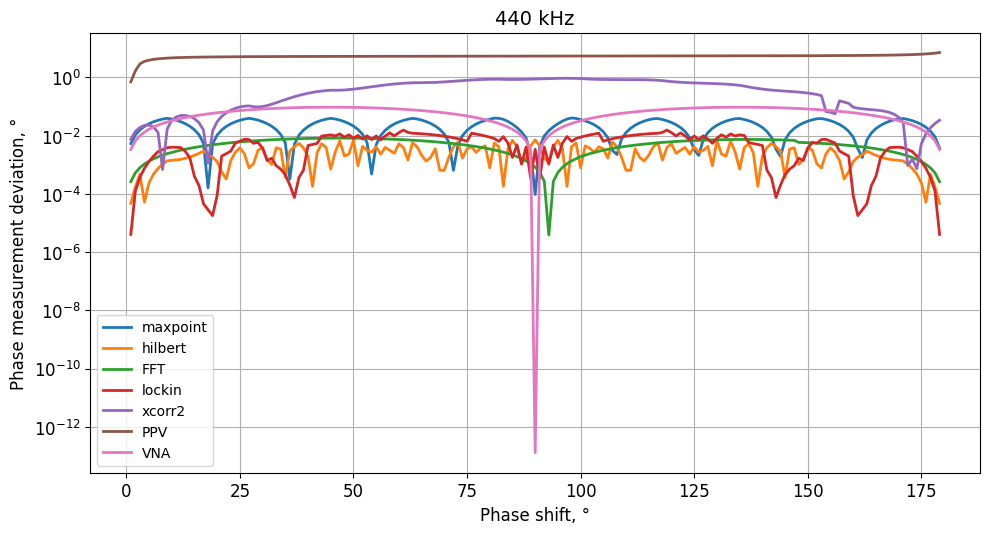

In [110]:
plot_for_one_F(phase_methods,phases_arrays, phase_diff_arrays,str(int(F/1000))+" kHz" )

Метод get_phase_VNA: 100%|██████████| 179/179 [00:00<00:00, 8875.94 шага/s]


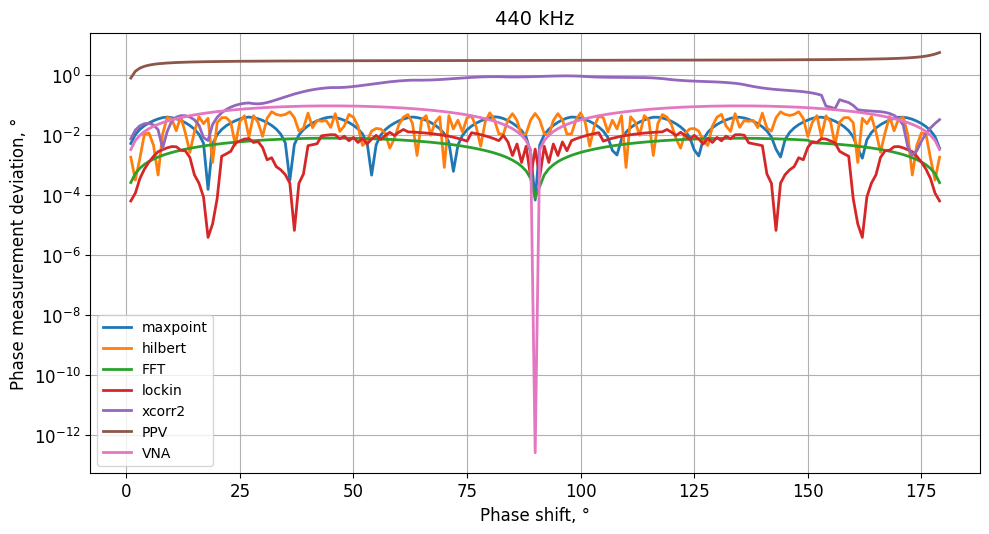

In [111]:
phases_arrays, phase_diff_arrays = variate_phase(*phase_methods,F=F,duration=30.5/F)
plot_for_one_F(phase_methods,phases_arrays, phase_diff_arrays,str(int(F/1000))+" kHz" )

In [112]:
from functools import reduce

summ_error_full = reduce(np.add, phase_diff_arrays)

summ_error_no_xcor = reduce(np.add, phase_diff_arrays[:4])

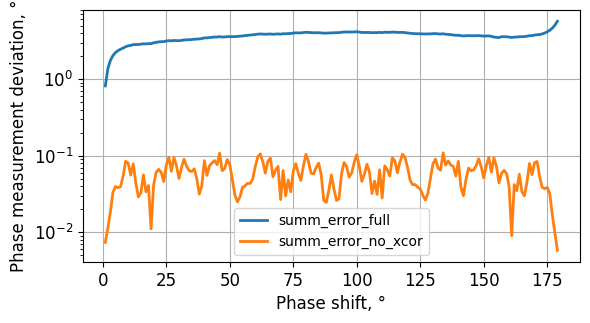

In [113]:
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 1)
front = 12
ax1 = fig.add_subplot(gs[0, 0])


ax1.plot(
    phases_arrays[0],
    np.abs(summ_error_full),
    label="summ_error_full",
    linewidth=2
)
ax1.plot(
    phases_arrays[0],
    np.abs(summ_error_no_xcor),
    label="summ_error_no_xcor",
    linewidth=2
)

ax1.set_xlabel('Phase shift, °', fontsize=front)
ax1.set_ylabel('Phase measurement deviation, °', fontsize=front)
ax1.tick_params(axis='both', labelsize=front)
ax1.grid(True)
ax1.legend(fontsize=10)
ax1.set_yscale('log')
plt.tight_layout()
plt.show()